## Power System Transient Stability Assessment Using Stacked Autoencoder and Voting Ensemble

Author: Dr. Petar Sarajcev, dipl.ing. (petar.sarajcev@fesb.hr)

University of Split, FESB, Department of Electrical Power Engineering

R. Boskovica 32, HR-21000, Split, Croatia, EU.

In [1]:
import timeit
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy import stats
from scipy import optimize

In [3]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.utils import class_weight

In [4]:
try:
    # Using experimental HalvingRandomSearchCV for hyperparameters optimization
    from sklearn.experimental import enable_halving_search_cv # noqa
    from sklearn.model_selection import HalvingRandomSearchCV
except ImportError:
    print('HalvingRandomSearchCV not found. Update scikit-learn to 0.24.')

In [5]:
from bayes_optim.bayesian_optimization import BayesianOptimization

In [6]:
# TensorFlow 2 -> Keras
from tensorflow import keras

In [7]:
import warnings

In [8]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [9]:
# Inline figures
%matplotlib inline

In [10]:
# Figure aesthetics from Seaborn
sns.set(context='paper', style='white', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

In [11]:
# An ancilary function for showing the confusion matrix, taken from:
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/mglearn/tools.py
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", fontsize=14):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", fontsize=fontsize)
    return img

In [12]:
def matthews_score(y_true, y_pred):
    """" Matthews correlation coeficient 

    Matthews coefficient ranges between -1 and +1. A coefficient of +1 
    represents a perfect prediction, 0 no better than random guessing 
    and -1 indicates a total disagreement between prediction and observation.

    Arguments
    ---------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    Returns
    -------
    matthews: float
        Matthews correlation coefficient between -1 and +1.
    """
    # Confusion matrix
    C_mat = metrics.confusion_matrix(y_true, y_pred)
    tn = C_mat[0,0]  # true negatives
    fn = C_mat[1,0]  # false negatives
    tp = C_mat[1,1]  # true positives
    fp = C_mat[0,1]  # false positives
    # Matthews coefficient
    matthews = (tp*tn - fp*fn) / np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    return matthews

In [13]:
def brier_score(y_labels, y_probas):
    """ Briers score for binary classification.

    Arguments
    ---------
    y_labels: array-like
        Array with actual class labels (zeros and ones).
    y_probas: array-like
        Array with probabilities of positive class (of class one).
    Returns
    -------
    BS: float
        Briers score value.
    """
    n_samples = len(y_labels)
    BS = np.sum((y_labels - y_probas)**2)/float(n_samples)
    return BS

### Power System Transient Stability Analysis Data (IEEE New England 39-bus Test Case)

In [14]:
data = pd.read_csv('GridDictionary2.csv')
data.head()

,WmG1,WmG2,WmG3,WmG4,WmG5,WmG6,WmG7,WmG8,WmG9,WmG10,...,VAlvB37,VBlvB37,VClvB37,VAlvB38,VBlvB38,VClvB38,VAlvB39,VBlvB39,VClvB39,Stability
0,1.0012,1.0038,1.0044,1.0019,1.0033,1.0025,1.0021,1.0018,1.0017,1.0027,...,1.06610,1.06610,1.06610,1.08410,1.08410,1.0841,1.0299,1.0299,1.0299,0
1,1.0004,1.0015,1.0007,1.0005,1.0014,1.0008,1.0007,1.0001,1.0002,1.0016,...,1.04680,1.04680,1.04680,1.04500,1.04500,1.0450,1.0103,1.0103,1.0103,0
2,1.0002,1.0018,1.0011,1.0015,1.0026,1.0019,1.0017,1.0029,1.0040,1.0038,...,0.94869,0.94867,0.94872,0.98802,0.98803,0.9880,1.0104,1.0104,1.0104,0
3,1.0007,1.0019,1.0007,1.0009,1.0021,1.0013,1.0012,1.0001,1.0005,1.0018,...,1.07170,1.07170,1.07170,1.07830,1.07830,1.0783,1.0255,1.0255,1.0255,0
4,1.0010,1.0032,1.0025,1.0045,1.0061,1.0079,1.0091,1.0024,1.0023,1.0038,...,1.03960,1.03960,1.03960,1.07580,1.07580,1.0758,1.0099,1.0099,1.0099,0


In [15]:
# Percentage of "ones" in the "Stability" column
print('There is {:.1f}% of unstable cases in the dataset!'
      .format(data['Stability'].sum()/float(len(data['Stability']))*100.))

There is 19.3% of unstable cases in the dataset!


### Data preprocessing and splitting

In [16]:
# Features and target
no_features = len(data.columns) - 1
X_data = data.iloc[:,0:no_features]  # features
print('X_data', X_data.shape)
y_data = data['Stability']

X_data (3120, 354)


#### Stratified Shuffle Split

In [17]:
# Stratified Shuffle Split dataset into train and test sets
# (stratified shuffle split preserves unbalance between categories,
# while shuffling and splitting data into train and test sets).
splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=365)
for train_idx, test_idx in splitter.split(X_data, y_data):
    X_train = X_data.loc[train_idx]
    y_train = y_data.loc[train_idx]
    X_test = X_data.loc[test_idx]
    y_test = y_data.loc[test_idx]

In [18]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)

X_train (2496, 354)
X_test (624, 354)


In [19]:
print('Unstable cases in training dataset: {:.1f}%:'.format(np.sum(y_train)/float(len(y_train))*100.))
print('Unstable cases in testing dataset {:.1f}%:'.format(np.sum(y_test)/float(len(y_test))*100.))

Unstable cases in training dataset: 19.3%:
Unstable cases in testing dataset 19.2%:


#### StandardScaler

In [20]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Undercomplete Denoising Stacked Autoencoder

In [21]:
# Reserving a portion of the training set for validation
# (using the Stratified Shuffle Split). This is only needed
# for training autoencoder and a neural network classifier.
splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.9, random_state=365)
for train_idx, test_idx in splitter.split(X_train, y_train.values):
    X_train_part = X_train[train_idx]
    y_train_part = y_train.values[train_idx]
    X_validation = X_train[test_idx]
    y_validation = y_train.values[test_idx]

In [22]:
print('X_train_part', X_train_part.shape)
print('X_validation', X_validation.shape)

X_train_part (2246, 354)
X_validation (250, 354)


In [23]:
# Codings dimension
DIMENSION = 16

In [24]:
# Reducing "no_features" to low dimensional space with autoencoder
input_layer = keras.layers.Input(shape=(no_features,))
# Denoising layer (GaussianNoise or Dropout)
denoise = keras.layers.Dropout(rate=0.25)(input_layer)
#denoise = keras.layers.GaussianNoise(stdev=0.25)(input_layer)  # alter.
# "encoded" is the encoded representation of the input
x = keras.layers.Dense(256, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(0.001))(denoise)
x = keras.layers.Dense(128, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(64, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(0.001))(x)
encoded = keras.layers.Dense(DIMENSION, activation='relu',  # encoder dimension
                             kernel_initializer='glorot_normal',
                             kernel_regularizer=keras.regularizers.l2(0.001))(x)
# "decoded" is the lossy reconstruction of the input
x = keras.layers.Dense(64, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(0.001))(encoded)
x = keras.layers.Dense(128, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(256, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(0.001))(x)
decoded = keras.layers.Dense(no_features, activation='linear', 
                             kernel_initializer='glorot_normal',
                             kernel_regularizer=keras.regularizers.l2(0.001))(x)
# Autoencoder
autoencoder = keras.models.Model(input_layer, decoded)
# Encoder
encoder = keras.models.Model(input_layer, encoded)
# Compile the model
lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-3,
        decay_steps=500, decay_rate=0.96, staircase=False)
adam_schedule = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder.compile(optimizer=adam_schedule, loss='kullback_leibler_divergence')
# Early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose=1)
# Train the autoencoder on the training data
history = autoencoder.fit(X_train_part, X_train_part, epochs=100, batch_size=32, 
                          shuffle=True, validation_data=(X_validation, X_validation), 
                          callbacks=[early_stopping], verbose=1)

Epoch 1/100
71/71 [==============================] - 2s 30ms/step - loss: 365.5386 - val_loss: 308.4489
Epoch 2/100
71/71 [==============================] - 2s 31ms/step - loss: 267.9869 - val_loss: 228.4203
Epoch 3/100
71/71 [==============================] - 2s 22ms/step - loss: 198.7733 - val_loss: 172.4029
Epoch 4/100
71/71 [==============================] - 1s 17ms/step - loss: 154.1076 - val_loss: 124.8067
Epoch 5/100
71/71 [==============================] - 2s 22ms/step - loss: 117.9969 - val_loss: 112.1509
Epoch 6/100
71/71 [==============================] - 2s 22ms/step - loss: 101.2339 - val_loss: 93.2891
Epoch 7/100
71/71 [==============================] - 1s 12ms/step - loss: 90.9611 - val_loss: 85.6953
Epoch 8/100
71/71 [==============================] - 1s 13ms/step - loss: 81.2650 - val_loss: 80.0641
Epoch 9/100
71/71 [==============================] - 1s 21ms/step - loss: 80.0767 - val_loss: 80.0565
Epoch 10/100
71/71 [==============================] - 1s 13ms/step - lo

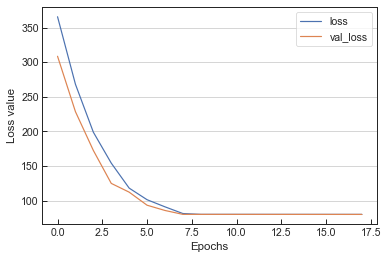

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(axis='y')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

#### Encode train and test data sets

In [26]:
# Encoding training data (with Monte Carlo sampling and averaging)
X_train_encoded = np.stack([encoder(X_train, training=True) for sample in range(100)]).mean(axis=0)
print(X_train_encoded.shape)
# Encoding testing data
X_test_encoded = np.stack([encoder(X_test, training=True) for sample in range(100)]).mean(axis=0)
print(X_test_encoded.shape)

(2496, 16)
(624, 16)



### Transfer learning from Autoencoder to DNN classifier

In [27]:
# Computing weights for the class balancing of the DNN classifier
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weights_dict)

{0: 0.6193548387096774, 1: 2.5945945945945947}


In [28]:
# Clone the encoder model
model_clone = keras.models.clone_model(encoder)
model_clone.set_weights(encoder.get_weights())
# Transfer learning from encoder to classifier
classifier_model = keras.models.Sequential(model_clone.layers[:-1])  # exclude last encoder layer
# Stack additional layers
classifier_model.add(keras.layers.Dense(128, activation='relu',
                                        kernel_initializer='glorot_normal',
                                        kernel_regularizer=keras.regularizers.l2(0.001)))
classifier_model.add(keras.layers.Dropout(0.2))
classifier_model.add(keras.layers.Dense(64, activation='relu',
                                        kernel_initializer='glorot_normal',
                                        kernel_regularizer=keras.regularizers.l2(0.001)))
classifier_model.add(keras.layers.Dropout(0.1))
classifier_model.add(keras.layers.Dense(1, activation='sigmoid'))
# Freezing layers (except newly added ones)
for layer in classifier_model.layers[:-5]:
    layer.trainable = False
EPOCHS = 200
BATCH_SIZE = 32
lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-3,
        decay_steps=200, decay_rate=0.96, staircase=False)
adam_schedule = keras.optimizers.Adam(learning_rate=lr_schedule)
classifier_model.compile(optimizer=adam_schedule, loss='binary_crossentropy', metrics=['AUC'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, 
        patience=25, verbose=1, restore_best_weights=True)
# Train the classifier (first pass)
classification_history = classifier_model.fit(X_train_part, y_train_part, epochs=EPOCHS, batch_size=BATCH_SIZE, 
        shuffle=True, validation_data=(X_validation, y_validation),
        class_weight=class_weights_dict, callbacks=[early_stopping], verbose=1)

Epoch 1/200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
71/71 [==============================] - 1s 16ms/step - loss: 0.9246 - auc: 0.9591 - val_loss: 0.8040 - val_auc: 0.9864
Epoch 2/200
71/71 [==============================] - 1s 15ms/step - loss: 0.8084 - auc: 0.9783 - val_loss: 0.7630 - val_auc: 0.9917
Epoch 3/200
71/71 [==============================] - 1s 13ms/step - loss: 0.7862 - auc: 0.9817 - val_loss: 0.7390 - val_auc: 0.9946
Epoch 4/200
71/71 [==============================] - 1s 13ms/step - loss: 0.7544 - auc: 0.9857 - val_loss: 0.7128 - val_auc: 0.9972
Epoch 5/200
71/71 [==============================] - 1s 11ms/step - loss: 0.7433 - auc: 0.9872 - val_loss: 0.7120 - val_auc: 0.9966
Epoch 6/200
71/71 [==============================] - 0s 5ms/step - loss: 0.7372 - auc: 0.9885 - val_loss: 0.6943 - val_auc: 0.9975
Epoch 7/200
71/71 [==============================] - 1s 10ms/step - loss: 0.7266 - auc: 0.9891 - val_loss: 0.6750 - val_auc: 0.9

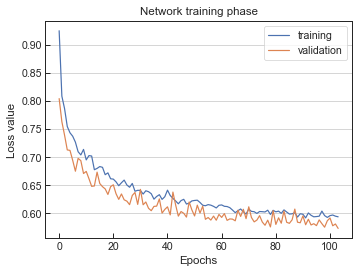

In [29]:
plt.figure(figsize=(5.5,4))
plt.title('Network training phase')
plt.plot(classification_history.history['loss'], label='training')
plt.plot(classification_history.history['val_loss'], label='validation')
plt.legend()
plt.grid(axis='y')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

In [30]:
classifier_model.layers

In [31]:
# Un-freezing selected layers for fine-tuning
for layer in classifier_model.layers[3:-5]:
    print(layer)
    layer.trainable = True

In [32]:
# Fine-tuning network weights with a reduced learning rate (second pass)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4,
        decay_steps=100, decay_rate=0.96, staircase=False)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, 
        patience=50, verbose=1, restore_best_weights=True)
classifier_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['AUC'])
fine_tuning_history = classifier_model.fit(X_train_part, y_train_part, epochs=EPOCHS, batch_size=BATCH_SIZE, 
        shuffle=False, validation_data=(X_validation, y_validation),
        class_weight=class_weights_dict, callbacks=[early_stopping], verbose=1)

Epoch 1/200
71/71 [==============================] - 2s 29ms/step - loss: 0.5966 - auc: 0.9979 - val_loss: 0.5847 - val_auc: 0.9996
Epoch 2/200
71/71 [==============================] - 1s 9ms/step - loss: 0.5986 - auc: 0.9976 - val_loss: 0.5890 - val_auc: 0.9997
Epoch 3/200
71/71 [==============================] - 1s 7ms/step - loss: 0.5942 - auc: 0.9979 - val_loss: 0.5787 - val_auc: 0.9996
Epoch 4/200
71/71 [==============================] - 1s 12ms/step - loss: 0.5856 - auc: 0.9986 - val_loss: 0.5750 - val_auc: 0.9996
Epoch 5/200
71/71 [==============================] - 1s 13ms/step - loss: 0.5984 - auc: 0.9971 - val_loss: 0.5747 - val_auc: 0.9995
Epoch 6/200
71/71 [==============================] - 1s 12ms/step - loss: 0.5912 - auc: 0.9979 - val_loss: 0.5827 - val_auc: 0.9996
Epoch 7/200
71/71 [==============================] - 1s 7ms/step - loss: 0.5872 - auc: 0.9978 - val_loss: 0.5810 - val_auc: 0.9995
Epoch 8/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5866

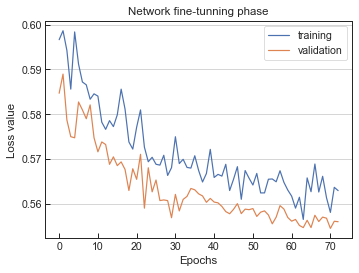

In [33]:
plt.figure(figsize=(5.5,4))
plt.title('Network fine-tunning phase')
plt.plot(fine_tuning_history.history['loss'], label='training')
plt.plot(fine_tuning_history.history['val_loss'], label='validation')
plt.legend()
plt.grid(axis='y')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

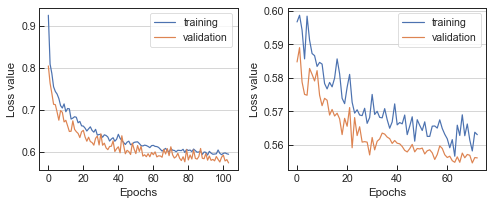

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
#ax[0].set_title('Network training phase')
ax[0].plot(classification_history.history['loss'], label='training')
ax[0].plot(classification_history.history['val_loss'], label='validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss value')
ax[0].legend(loc='upper right')
ax[0].grid(axis='y')
#ax[1].set_title('Network fine-tuning phase')
ax[1].plot(fine_tuning_history.history['loss'], label='training')
ax[1].plot(fine_tuning_history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss value')
ax[1].legend(loc='upper right')
ax[1].grid(axis='y')
fig.tight_layout()
plt.show()


In [35]:
y_scores = classifier_model.predict(X_test).flatten()

In [36]:
y_scores.shape

(624,)

In [37]:
# Precision/recall trade-off 
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_scores)
# Find a best threshold value (where precision and recall curves intersect)
EPSILON = 1e-3  # Tolerance
THRESHOLD = thresholds[np.argwhere(abs(precisions - recalls) < EPSILON)][0][0]
print(THRESHOLD)

0.80902815


In [38]:
def precision_recall_tradeoff(thresholds, precisions, recalls, threshold, title=''):
    fig, ax = plt.subplots(figsize=(5.5,3.5))
    ax.set_title(title)
    ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
    ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
    plt.vlines(threshold, 0, 1, linestyles='--', color='dimgrey', 
               label='Threshold = {:.2f}'.format(threshold))
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Precision / Recall')
    ax.legend(loc='center left')
    ax.grid()
    fig.tight_layout()
    plt.show()
    return

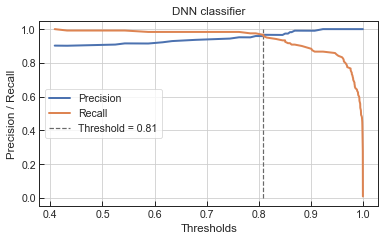

In [39]:
# Show precision/recall curves
precision_recall_tradeoff(thresholds, precisions, recalls, THRESHOLD, title='DNN classifier')

In [40]:
pred = np.where(y_scores >= THRESHOLD, 1, 0)

In [41]:
# Monte Carlo predictions
predictions = np.stack([classifier_model(X_test, training=True) for sample in range(100)])
predictions = predictions.reshape(100, -1)
predictions.shape

(100, 624)

In [42]:
# Showing boxplots for select cases
predicts = pd.DataFrame(predictions[:,[11,12,13,16,19]], columns=['Case {:d}'.format(i+1) for i in range(5)])

/home/ps/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 83.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


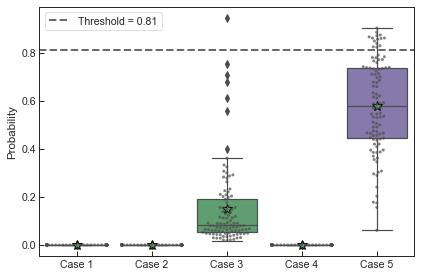

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=predicts, orient='v', ax=ax, showmeans=True, 
            meanprops={'marker': '*', 'markeredgecolor': 'black', 'markersize': '10'})
sns.swarmplot(data=predicts, orient='v', size=3, color='.3', alpha=0.7, ax=ax)
ax.axhline(THRESHOLD, ls='--', lw=2, color='dimgrey', label='Threshold = {:.2f}'.format(THRESHOLD))
ax.legend(loc='upper left')
ax.set_ylabel('Probability')
fig.tight_layout()
plt.show()

In [44]:
def show_confusion_matrix(y_true, y_pred, labels, title):
    scores_image = heatmap(metrics.confusion_matrix(y_true, y_pred), xlabel='Predicted label', 
                       ylabel='True label', xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    return

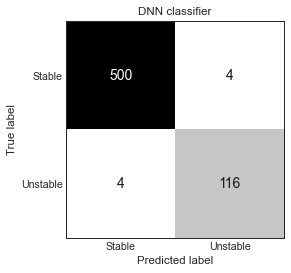

In [45]:
labels = ['Stable', 'Unstable']
# confusion matrix
show_confusion_matrix(y_test, pred, labels, title='DNN classifier')

In [46]:
# classification report
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       0.99      0.99      0.99       504
    Unstable       0.97      0.97      0.97       120

    accuracy                           0.99       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.99      0.99      0.99       624



In [47]:
dnn_data = pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred),
                   metrics.f1_score(y_test, pred), matthews_score(y_test, pred), brier_score(y_test, y_scores)],
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1-score", "matthews", "brier"], columns=['Values'])

### Support Vector Machine classifier

#### Bayesian optimization of hyperparameters

In [48]:
def svc_cv(data, targets, C, gamma, kernel='rbf'):
    """ SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    The goal is to find combinations of C and epsilon that maximizes the
    f1 scoring metric.
    Arguments:
    C - Regularization parameter (penalty is a squared l2). 
    gamma - Kernel coefficient.
    """
    estimator = svm.SVC(C=C, gamma=gamma, kernel=kernel, 
                        class_weight='balanced', probability=True)
    cval = cross_val_score(estimator, data, targets, scoring='f1', cv=3, n_jobs=-1)
    return cval.mean()


def optimize_svc(data, targets, kernel, N):
    """ Apply Bayesian Optimization to SVC parameters."""

    if kernel not in ['poly', 'rbf', 'sigmoid']:
        raise NotImplementedError('Kernel: {} is not recognized or implemented.'.format(kernel))

    def svc_crossval(expC, expGamma):
        """ Wrapper of SVC cross validation.
        Notice the transform between regular and log scale. 
        While this is not technically necessary, it greatly 
        improves the performance of the BO optimizer.
        """
        C = 10**expC
        gamma = 10**expGamma
        model_instance = svc_cv(C=C, gamma=gamma, kernel=kernel, data=data, targets=targets)
        return model_instance
    
    # Bayesian Optimization
    optimizer = BayesianOptimization(f=svc_crossval,
                                     pbounds={'expC':(-2,3), 'expGamma':(-4,1)}, 
                                     verbose=1)
    optimizer.maximize(init_points=10, n_iter=N)
    return optimizer.max


In [49]:
# Bayesian optimization for SVM hyperparameter selection
kernel = 'rbf'  # Radial basis function (RBF) kernel
N = 50  # Number of iterations
best_parameters_svc = optimize_svc(X_train_encoded, y_train, kernel=kernel, N=N)
print("Best parameters from Bayesian Optimization: {}".format(best_parameters_svc['params']))

|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  2        |  0.932    |  1.388    | -2.034    |
|  4        |  0.9585   |  1.741    | -0.2045   |
|  5        |  0.9682   |  2.745    | -1.404    |
|  24       |  0.9685   |  3.0      | -1.898    |
|  28       |  0.9694   |  2.246    | -1.574    |
|  40       |  0.9722   |  3.0      | -1.66     |
Best parameters from Bayesian Optimization: {'expC': 2.99952587370316, 'expGamma': -1.6602663090261434}


In [50]:
# Instantiate optimal SVC estimator and fit to data
C_best = 10**best_parameters_svc['params']['expC']
gamma_best = 10**best_parameters_svc['params']['expGamma']
best_parameters_svc = {'C':C_best, 'gamma':gamma_best}
svcb = svm.SVC(C=C_best, gamma=gamma_best, kernel=kernel,
               class_weight='balanced', probability=True)
svcb.fit(X_train_encoded, y_train)

SVC(C=998.908879561968, class_weight='balanced', gamma=0.021864205015152998,
    probability=True)

#### Training several SVM classifiers using random samples with replacement (i.e. bootstrap) from the training data

In [51]:
n_models = 3
sample_size = 1000
svc_model_parameters = {}
rng = np.random.default_rng()
for i in range(n_models):
    # Generate a random sample with replacement from the encoded training data
    indices = np.arange(len(y_train))
    indices_sample = rng.choice(indices, size=sample_size, replace=True)
    X_train_encoded_sample = X_train_encoded[indices_sample, :]
    y_train_sample = y_train.values[indices_sample]
    # Train SVM instance using Bayesian optimization
    params_svc = optimize_svc(X_train_encoded_sample, y_train_sample, kernel=kernel, N=N)
    C = 10**params_svc['params']['expC']
    gamma = 10**params_svc['params']['expGamma']
    svc_model_parameters[i] = {'C':C, 'gamma':gamma}


|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  4        |  0.9485   |  2.253    | -0.6683   |
|  14       |  0.9664   |  3.0      | -1.571    |
|  17       |  0.9716   |  2.301    | -1.369    |
|  24       |  0.9767   |  2.235    | -1.113    |
|  49       |  0.9768   |  2.396    | -1.216    |
|  59       |  0.9792   |  2.286    | -1.086    |
|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  10       |  0.9461   |  2.322    | -2.073    |
|  26       |  0.9553   |  1.407    | -1.611    |
|  30       |  0.9575   |  1.869    | -1.743    |
|  40       |  0.9591   |  2.228    | -1.68     |
|  47       |  0.961    |  2.11     | -1.511    |
|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  4        |  0.9559   | -0.2781   | -0.2408   |
|  5        |  0.9637   |  0.4423   | -1.626    |
|  15       |  0.97     |  2.997    | -2.407    |


In [52]:
svc_model_parameters

{0: {'C': 193.2968204593881, 'gamma': 0.08198004123930902},
 1: {'C': 128.94920936082306, 'gamma': 0.03083323992246561},
 2: {'C': 967.7775235760878, 'gamma': 0.008561331185948592}}

In [53]:
# Refit SVM instances using all encoded training data
svc_models = []
for i in range(n_models):
    model_params = svc_model_parameters[i]
    svc = svm.SVC(C=model_params['C'], gamma=model_params['gamma'],
                  kernel=kernel, class_weight='balanced', probability=True)
    svc.fit(X_train_encoded, y_train)
    svc_models.append(svc)

#### Random Search for hyperparameters tuning

In [54]:
# Comparison: Random Search instead of the Bayesian Optimization
parameters = {'C':stats.expon(scale=10), 'gamma':stats.expon(scale=.1)}
svcr = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True, 
                                            class_weight='balanced'), 
                          param_distributions=parameters, cv=3, 
                          n_iter=100,  # no. iterations
                          scoring='f1',  # scoring method
                          refit=True, n_jobs=-1)
svcr.fit(X_train_encoded, y_train)
# Best model parameters
best_parameters_svc = svcr.best_params_
print("Best parameters from RandomSearch: {}".format(best_parameters_svc))


Best parameters from RandomSearch: {'C': 35.59897890820265, 'gamma': 0.132920885291038}


In [55]:
# Choose SVM based on the hyperparameter 
# optimization method
BO = True
if BO:
    # Bayesian Optimization
    svc = svcb
else:
    # Random Search
    svc = svcr

In [56]:
# Predict class probability on test data
y_probas_svc = svc.predict_proba(X_test_encoded)
# score == probability of positive class
y_scores_svc = y_probas_svc[:,1]
precisions2, recalls2, thresholds2 = metrics.precision_recall_curve(y_test, y_scores_svc)
# Find a best threshold value (where precision and recall curves intersect)
THRESHOLD2 = thresholds2[np.argwhere(abs(precisions2 - recalls2) < EPSILON)][0][0]
print(THRESHOLD2)

0.2929122530433825


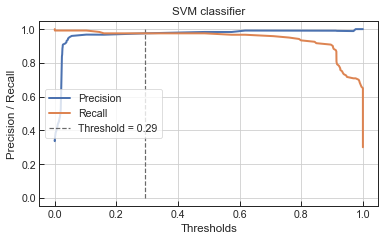

In [57]:
# Show precision/recall curves
precision_recall_tradeoff(thresholds2, precisions2, recalls2, THRESHOLD2, title='SVM classifier')

In [58]:
# Predict class on test data
svc_pred = np.where(y_scores_svc >= THRESHOLD2, 1, 0)

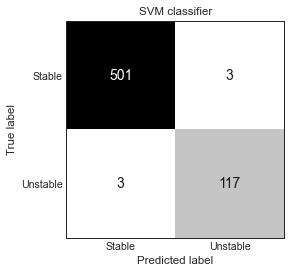

In [59]:
# confusion matrix
show_confusion_matrix(y_test, svc_pred, labels, title='SVM classifier')

In [60]:
# classification report
print(metrics.classification_report(y_test, svc_pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       0.99      0.99      0.99       504
    Unstable       0.97      0.97      0.97       120

    accuracy                           0.99       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.99      0.99      0.99       624



In [61]:
svm_data = pd.DataFrame(data=[metrics.accuracy_score(y_test, svc_pred), metrics.recall_score(y_test, svc_pred),
                   metrics.precision_score(y_test, svc_pred), metrics.roc_auc_score(y_test, svc_pred),
                   metrics.f1_score(y_test, svc_pred), matthews_score(y_test, svc_pred), brier_score(y_test, y_scores_svc)], 
                  index=["accuracy", "recall", "precision", "roc_auc_score", "f1-score", "matthews", "brier"], columns=['Values'])

### Random Forest classifier

In [62]:
# Choose a search method for hyperparameters optimization
search_type = 'RandomizedSearchCV'

In [63]:
# RandomForestClassifier (ensemble learner for classification)
parameters = {'n_estimators': stats.randint(low=200, high=1000), 
              'criterion':['gini', 'entropy'],
              'max_samples': stats.uniform(loc=0.3, scale=0.7),
              'max_features': stats.randint(low=DIMENSION, high=X_train_encoded.shape[1]+1),
              'min_samples_split': stats.randint(low=2, high=11),
              'max_depth': [1, 3, 5, None],
              'bootstrap': [True, False],
              }
time_start = timeit.default_timer()
if search_type == 'RandomizedSearchCV':
    # Randomized search with cross-validation for hyper-parameters optimisation
    forest = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), 
                                param_distributions=parameters, cv=3, 
                                n_iter=100,  # no. iterations
                                scoring='f1',  
                                refit=True, n_jobs=-1) 
    forest.fit(X_train_encoded, y_train)
elif search_type == 'HalvingRandomSearchCV':  # EXPERIMENTAL
    # Halving randomized search with cross-validation for hyper-parameters optimisation
    forest = HalvingRandomSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), 
                                   param_distributions=parameters, cv=3, scoring='f1',  
                                   refit=True, n_jobs=-1) 
    forest.fit(X_train_encoded, y_train)
else:
    raise NotImplementedError('Search method "{}" is not recognized or implemented!'.format(search_type))
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

Execution time (hour:min:sec): 0:02:34.305593


In [64]:
best_forest_parameters = forest.best_params_
print("Best parameters: {}".format(forest.best_params_))

Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 16, 'max_samples': 0.7247574925211193, 'min_samples_split': 4, 'n_estimators': 287}


In [65]:
# Predict class probability on test data
y_probas_forest = forest.predict_proba(X_test_encoded)
# score == probability of positive class
y_scores_forest = y_probas_forest[:,1]
precisions3, recalls3, thresholds3 = metrics.precision_recall_curve(y_test, y_scores_forest)
# Find a best threshold value (where precision and recall curves intersect)
THRESHOLD3 = thresholds3[np.argwhere(abs(precisions3 - recalls3) < EPSILON)][0][0]
print(THRESHOLD3)

0.5603772910648371


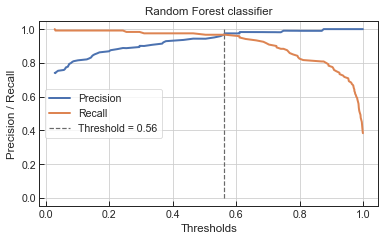

In [66]:
# Show precision/recall curves
precision_recall_tradeoff(thresholds3, precisions3, recalls3, THRESHOLD3, title='Random Forest classifier')

In [67]:
# Predict class on test data
forest_pred = np.where(y_scores_forest >= THRESHOLD3, 1, 0)

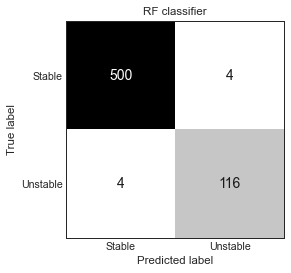

In [68]:
# confusion matrix
show_confusion_matrix(y_test, forest_pred, labels, title='RF classifier')

In [69]:
# classification report
print(metrics.classification_report(y_test, forest_pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       0.99      0.99      0.99       504
    Unstable       0.97      0.97      0.97       120

    accuracy                           0.99       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.99      0.99      0.99       624



In [70]:
forest_data = pd.DataFrame(data=[metrics.accuracy_score(y_test, forest_pred), metrics.recall_score(y_test, forest_pred),
                   metrics.precision_score(y_test, forest_pred), metrics.roc_auc_score(y_test, forest_pred),
                   metrics.f1_score(y_test, forest_pred), matthews_score(y_test, forest_pred), brier_score(y_test, y_scores_forest)], 
                index=["accuracy", "recall", "precision", "roc_auc_score", "f1-score", "matthews", "brier"], columns=['Values'])

### Soft Voting Ensemble

#### Ensemble classifier's weights optimization

In [71]:
# Loss function for the weights optimization
def loss_function(weights):
    final_prediction = 0.
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction
    # using scikit-learn loss for the classification
    loss_value = metrics.log_loss(y_test, final_prediction)
    return loss_value

In [72]:
# Ensemble weights for a pool of SVM classifiers only
predictions = []
for i in range(n_models):
    svc = svc_models[i]
    y_proba = svc.predict_proba(X_test_encoded)
    predictions.append(y_proba)

start_vals = [1./len(predictions)]*len(predictions)
constr = ({'type':'eq','fun':lambda w: 1. - np.sum(w)})
bounds = [(0., 1.)]*len(predictions)
res = optimize.minimize(loss_function, start_vals, method='SLSQP', 
                        bounds=bounds, constraints=constr)
weights_svm = res['x']
print('Optimal weights with SVM pool: {}; Sum of weights: {}'
      .format(weights_svm.round(3), weights_svm.sum()))

Optimal weights with SVM pool: [0.606 0.    0.394]; Sum of weights: 1.0000000000000004


In [73]:
# Based on the optimal weights vector we can identify which 
# SVM instance performed best within the pool of instances.
index_max = weights_svm.argmax()
select_model_parameters = svc_model_parameters[index_max]
select_model_y_probas = predictions[index_max]

In [74]:
# Ensemble weights for SVM and RF classifiers.
# Add predictions of other base models as needed.
# Oredring of "y_probas" is important for later!
POOL = True
if POOL:
    # Using winner of the pool
    predictions = [select_model_y_probas, y_probas_forest]
else:
    predictions = [y_probas_svc, y_probas_forest]
# Initial values
start_vals = [1./len(predictions)]*len(predictions)
# Constraints:
constr = ({'type':'eq','fun':lambda w: 1. - np.sum(w)})
# weights are bound between 0 and 1
bounds = [(0., 1.)]*len(predictions)
# Minimize loss function: scipy.optimize.minimize 
# Using SLSQP method with constraints.
res = optimize.minimize(loss_function, start_vals, method='SLSQP', 
                        bounds=bounds, constraints=constr)
weights = res['x']  # ensemble model's weights
print('Optimal weights: {}; Sum of weights: {}'.format(weights.round(3), weights.sum()))


Optimal weights: [0.784 0.216]; Sum of weights: 1.0


#### VotingClassifier

In [75]:
# Instantiate individual classifiers with their optimal hyperparameters.
# Ordering of models needs to be consistent with computed ensemble weights.
if POOL:
    estimator_svc = svm.SVC(kernel='rbf', probability=True, class_weight='balanced', **select_model_parameters)
else:
    estimator_svc = svm.SVC(kernel='rbf', probability=True, class_weight='balanced', **best_parameters_svc)
estimator_rf = RandomForestClassifier(class_weight='balanced', **best_forest_parameters)
ensemble = VotingClassifier(estimators={('svm', estimator_svc), ('rf', estimator_rf)}, 
                            weights=weights.round(3), # weights list
                            voting='soft', n_jobs=-1)
ensemble.fit(X_train_encoded, y_train)

VotingClassifier(estimators={('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_features=16,
                                                     max_samples=0.7247574925211193,
                                                     min_samples_split=4,
                                                     n_estimators=287)),
                             ('svm',
                              SVC(C=193.2968204593881, class_weight='balanced',
                                  gamma=0.08198004123930902,
                                  probability=True))},
                 n_jobs=-1, voting='soft', weights=array([0.784, 0.216]))

In [76]:
y_probas_ensemble = ensemble.predict_proba(X_test_encoded)

In [77]:
# score == probability of positive class
y_scores_ensemble = y_probas_ensemble[:,1]
precisions4, recalls4, thresholds4 = metrics.precision_recall_curve(y_test, y_scores_ensemble)
# Find a best threshold value (where precision and recall curves intersect)
THRESHOLD4 = thresholds4[np.argwhere(abs(precisions4 - recalls4) < EPSILON)][0][0]
print(THRESHOLD4)

0.28254863421936055


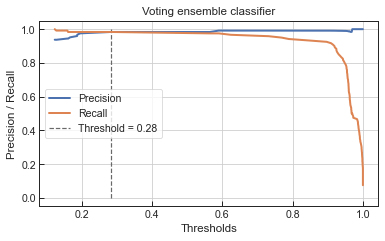

In [78]:
# Show precision/recall curves
precision_recall_tradeoff(thresholds4, precisions4, recalls4, THRESHOLD4, title='Voting ensemble classifier')

In [79]:
# Predict class on test data
ensemble_pred = np.where(y_scores_ensemble >= THRESHOLD4, 1, 0)

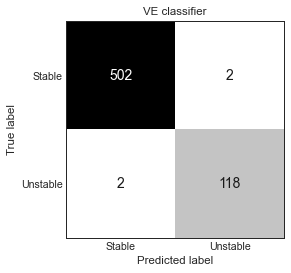

In [80]:
# confusion matrix
show_confusion_matrix(y_test, ensemble_pred, labels, title='VE classifier')

In [81]:
# classification report
print(metrics.classification_report(y_test, ensemble_pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00       504
    Unstable       0.98      0.98      0.98       120

    accuracy                           0.99       624
   macro avg       0.99      0.99      0.99       624
weighted avg       0.99      0.99      0.99       624



In [82]:
ensemble_data = pd.DataFrame(data=[metrics.accuracy_score(y_test, ensemble_pred), metrics.recall_score(y_test, ensemble_pred),
                   metrics.precision_score(y_test, ensemble_pred), metrics.roc_auc_score(y_test, ensemble_pred),
                   metrics.f1_score(y_test, ensemble_pred), matthews_score(y_test, ensemble_pred), brier_score(y_test, y_scores_ensemble)], 
                index=["accuracy", "recall", "precision", "roc_auc_score", "f1-score", "matthews", "brier"], columns=['Values'])

### Classifier performance comparison

In [83]:
data = dnn_data.join(svm_data, lsuffix='_dnn', rsuffix='_svm')
data['Values_forest'] = forest_data
data['Values_voting'] = ensemble_data
data

,Values_dnn,Values_svm,Values_forest,Values_voting
accuracy,0.987179,0.990385,0.987179,0.993590
recall,0.966667,0.975000,0.966667,0.983333
precision,0.966667,0.975000,0.966667,0.983333
roc_auc_score,0.979365,0.984524,0.979365,0.989683
f1-score,0.966667,0.975000,0.966667,0.983333
matthews,0.958730,0.969048,0.958730,0.979365
brier,0.013940,0.007748,0.013156,0.006697


#### Visualize receiver operating characteristic (ROC) curves

In [84]:
def f1_score(precision, recall):
    """ F1-metric score from precision and recall """
    return 2.*(precision*recall)/(precision + recall)

In [85]:
h = 0.1; delta = 0.01
x_min, x_max = 0, 1
y_min, y_max = 0, 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))
Z = f1_score(xx.ravel(), yy.ravel())
Z = Z.reshape(xx.shape)

<ipython-input-84-bc219bd3ee6f>:3: RuntimeWarning: invalid value encountered in true_divide
  return 2.*(precision*recall)/(precision + recall)


In [86]:
# Matplotlib inset figure
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [87]:
precisions_all = [precisions, precisions2, precisions3, precisions4]
recalls_all = [recalls, recalls2, recalls3, recalls4]
thresholds_all = [thresholds, thresholds2, thresholds3, thresholds4]
THRESHOLDS_ALL = [THRESHOLD, THRESHOLD2, THRESHOLD3, THRESHOLD4]
classifiers_all = ['DNN', 'SVM', 'RF', 'VE']

<ipython-input-88-7b89725448a4>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


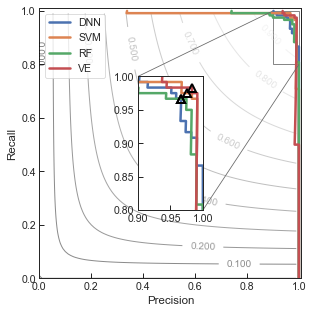

In [88]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
CS = ax.contour(xx, yy, Z, levels=10, linewidths=1, linestyles='-', alpha=0.5, cmap=plt.cm.gist_gray)
ax.clabel(CS, inline=True, fontsize=10)  # Iso-F1 curves
for pr, re, cl in zip(precisions_all, recalls_all, classifiers_all):
    ax.plot(pr, re, lw=2.5, ls='-', label=cl)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.legend(loc='upper left')
ax.set_xlim(0, 1.01)
ax.set_ylim(0, 1.01)
# Inset figure with a zoomed-in region of interest
axins = zoomed_inset_axes(ax, zoom=2.5, loc='center')
axins.set_xlim(0.9, 1.0)
axins.set_ylim(0.8, 1.0)
for pr, re, cl in zip(precisions_all, recalls_all, classifiers_all):
    axins.plot(pr, re, lw=2.5, ls='-', label=cl)
# Show threshold valuess
for pr, re, th, TH in zip(precisions_all, recalls_all, thresholds_all, THRESHOLDS_ALL):
    tv = np.argmin(np.abs(th - TH))
    axins.plot(pr[tv], re[tv], '^', c='black', markersize=8, fillstyle='none', mew=2)
# Inset axis markers
axins.yaxis.get_major_locator().set_params(nbins=4)
axins.xaxis.get_major_locator().set_params(nbins=2)
#plt.setp(axins.get_xticklabels(), visible=False)
#plt.setp(axins.get_yticklabels(), visible=False)
# draw a box of the region of the inset axes in the parent axes 
# and connecting lines between the box and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='dimgrey')
fig.tight_layout()
plt.show()

#### Visualize detection error trade-off (DET) curve

In [89]:
from det_curve_metrics import det_curve

In [90]:
fprs = []
fnrs = []
thrs = []
cls_names = ['DNN', 'SVM', 'RF', 'VE']
cls_probas = [y_scores, y_scores_svc, y_scores_forest, y_scores_ensemble]
for name, y_probas in zip(cls_names, cls_probas):
    fpr, fnr, thr = det_curve(y_test.values, y_probas)
    fprs.append(fpr)
    fnrs.append(fnr)
    thrs.append(thr)

<ipython-input-91-9251573526df>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


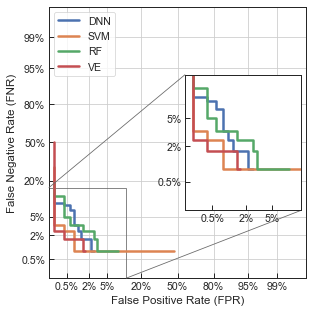

In [91]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
for name, fpr, fnr in zip(cls_names, fprs, fnrs):
    ax.plot(stats.norm.ppf(fpr), stats.norm.ppf(fnr), lw=2.5, ls='-', label=name)
#ticks = [0.001, 0.01, 0.05, 0.20, 0.50, 0.80, 0.95, 0.99, 0.999]
ticks = [0.001, 0.005, 0.02, 0.05, 0.20, 0.50, 0.80, 0.95, 0.99, 0.999]
tick_locations = stats.norm.ppf(ticks)
tick_labels = ['{:.0%}'.format(s) if (100*s).is_integer() 
               else '{:.1%}'.format(s) for s in ticks]
ax.set_xticks(tick_locations)
ax.set_xticklabels(tick_labels)
ax.set_xlim(-3, 3)
ax.set_yticks(tick_locations)
ax.set_yticklabels(tick_labels)
ax.set_ylim(-3, 3)
ax.grid()
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('False Negative Rate (FNR)')
ax.legend(loc='upper left')
# Inset figure with a zoomed-in region of interest
axins = zoomed_inset_axes(ax, zoom=1.5, loc='center right')
axins.set_xticks(tick_locations)
axins.set_xticklabels(tick_labels)
axins.set_yticks(tick_locations)
axins.set_yticklabels(tick_labels)
axins.set_xlim(-3, -1.2)
axins.set_ylim(-3, -1)
#axins.grid()
for name, fpr, fnr in zip(cls_names, fprs, fnrs):
    axins.plot(stats.norm.ppf(fpr), stats.norm.ppf(fnr), lw=2.5, ls='-', label=name)
# draw a box of the region of the inset axes in the parent axes 
# and connecting lines between the box and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='dimgrey')
fig.tight_layout()
plt.show()

### Classifier reliability plots

In [92]:
# Support Vector Machine classifier
calibrated_svc = CalibratedClassifierCV(estimator_svc, method='sigmoid', cv=3)
calibrated_svc.fit(X_train_encoded, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=193.2968204593881,
                                          class_weight='balanced',
                                          gamma=0.08198004123930902,
                                          probability=True),
                       cv=3)

In [93]:
svc_prob_pos = calibrated_svc.predict_proba(X_test_encoded)[:, 1]

In [94]:
# Random Forest classifier
calibrated_rf = CalibratedClassifierCV(estimator_rf, method='sigmoid', cv=3)
calibrated_rf.fit(X_train_encoded, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                             criterion='entropy',
                                                             max_features=16,
                                                             max_samples=0.7247574925211193,
                                                             min_samples_split=4,
                                                             n_estimators=287),
                       cv=3)

In [95]:
rf_prob_pos = calibrated_rf.predict_proba(X_test_encoded)[:, 1]

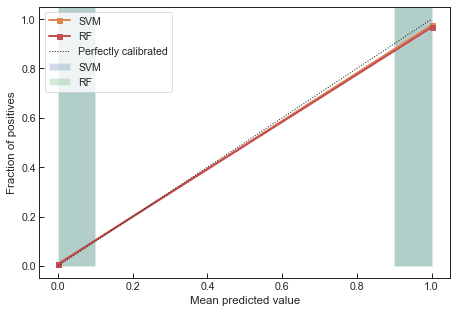

In [96]:
# Classifier reliability plots
fig, ax = plt.subplots(figsize=(6.5,4.5))
# Un-comment the following line to show CalibratedClassifierCV results
#for name, prob_pos in [('SVM', svc_prob_pos), ('RF', rf_prob_pos)]:
# Show reliability plot for previously calibrated classifiers
for name, prob_pos in [('SVM', svc_pred), ('RF', forest_pred)]:
    # Calibration curve (reliability plot)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    ax.hist(prob_pos, range=(0, 1), bins=10, density=True,
            histtype='stepfilled', lw=0.5, alpha=0.25, label=name)
    ax.plot(mean_predicted_value, fraction_of_positives, ls='-', lw=2, marker='s', ms=5, label=name)
ax.plot([0, 1], [0, 1], 'k:', lw=1, label='Perfectly calibrated')
ax.legend(loc='upper left')
ax.set_xlabel('Mean predicted value')
ax.set_ylabel('Fraction of positives')
ax.set_ylim([-0.05, 1.05])
fig.tight_layout()
plt.show()